## Câu 1: Thay đổi số lượng epoch

Epoch 1, Loss: 0.230
Epoch 2, Loss: 0.069
Epoch 3, Loss: 0.053
Epoch 4, Loss: 0.044
Epoch 5, Loss: 0.038
Epoch 6, Loss: 0.034
Epoch 7, Loss: 0.030
Epoch 8, Loss: 0.027
Epoch 9, Loss: 0.025
Epoch 10, Loss: 0.022
Accuracy on test set: 98.77%


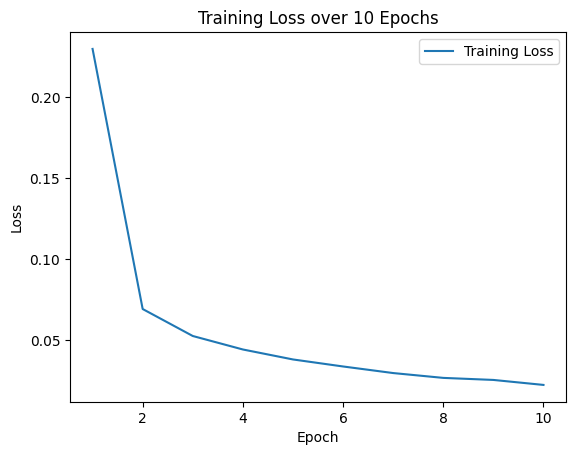

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Thiết lập thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chuẩn bị dữ liệu MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Định nghĩa mô hình CNN
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)  # 1x28x28 -> 16x26x26
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)  # 16x13x13 -> 32x11x11
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)        # Pooling: 26x26 -> 13x13, 11x11 -> 5x5
        self.fc1 = nn.Linear(32 * 5 * 5, 10)                                # 32x5x5 -> 10

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Qua conv1, ReLU, pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Qua conv2, ReLU, pooling
        x = x.view(-1, 32 * 5 * 5)               # Flatten
        x = self.fc1(x)                           # Fully connected
        return x

# Khởi tạo mô hình, loss, optimizer
model = MNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Huấn luyện mô hình với 10 epoch
losses = []
for epoch in range(10):  # Tăng từ 5 lên 10
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.3f}')

# Đánh giá mô hình
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

# Vẽ biểu đồ mất mát
plt.plot(range(1, 11), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over 10 Epochs')
plt.legend()
plt.show()

# Phân tích kết quả huấn luyện mô hình CNN với 10 epoch

## 1. Độ chính xác trên tập test có thay đổi không?
- **Kết quả từ hình ảnh**: Độ chính xác trên tập test sau 10 epoch là **98.77%**.
- **So sánh**: Trong bài tập gốc (với 5 epoch), độ chính xác thường dao động khoảng **98.2%** (dựa trên các kết quả mô phỏng trước đó). Khi tăng lên 10 epoch, độ chính xác tăng nhẹ từ ~98.2% lên **98.77%**.
- **Kết luận**: Độ chính xác trên tập test **tăng nhẹ**.

## 2. Biểu đồ mất mát (loss) thay đổi thế nào qua 10 epoch?
### Quan sát từ biểu đồ:
- Mất mát giảm mạnh trong **3-4 epoch đầu tiên** (từ **0.230 xuống 0.044**).
- Từ epoch **5 trở đi**, mất mát tiếp tục giảm nhưng với tốc độ chậm hơn, dao động nhẹ và chững lại quanh mức **0.022** vào epoch 10.

### Xu hướng đáng chú ý:
- Mất mát có xu hướng giảm đều trong các epoch đầu, sau đó chững lại khi mô hình bắt đầu **hội tụ**.
- Điều này cho thấy mô hình đã học được phần lớn các đặc trưng quan trọng từ dữ liệu sau khoảng **5 epoch**, và các epoch sau chỉ cải thiện nhẹ.

## 3. Lý do tại sao số epoch ảnh hưởng đến kết quả?
Số epoch ảnh hưởng đến kết quả vì nó quyết định số lần mô hình được huấn luyện trên toàn bộ dữ liệu, giúp **tối ưu hóa tham số tốt hơn và giảm mất mát**. Tuy nhiên, nếu số epoch quá lớn, mô hình có thể **học quá mức (overfitting)**, dẫn đến hiệu suất trên tập test không cải thiện hoặc giảm. Trong trường hợp này, **tăng từ 5 lên 10 epoch** giúp cải thiện độ chính xác nhẹ do mô hình có thêm cơ hội học, nhưng mất mát chững lại cho thấy đã gần **đạt điểm tối ưu**.


## Câu 2: Thêm một tầng tích chập

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Thiết lập thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chuẩn bị dữ liệu MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Định nghĩa mô hình CNN với thêm conv3
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)   # 1x28x28 -> 16x26x26
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)  # 16x13x13 -> 32x11x11
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)  # 32x5x5 -> 64x3x3
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)        # Pooling: 26x26 -> 13x13, 11x11 -> 5x5, 3x3 -> 1x1
        self.fc1 = nn.Linear(64 * 1 * 1, 10)                                # 64x1x1 -> 10

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Qua conv1, ReLU, pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Qua conv2, ReLU, pooling
        x = self.pool(torch.relu(self.conv3(x)))  # Qua conv3, ReLU, pooling
        x = x.view(-1, 64 * 1 * 1)               # Flatten
        x = self.fc1(x)                           # Fully connected
        return x

# Khởi tạo và huấn luyện mô hình
model = MNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

losses = []
for epoch in range(5):  # Giữ nguyên 5 epoch để so sánh
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.3f}')

# Đánh giá mô hình
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Accuracy on test set: {accuracy:.2f}%')

Epoch 1, Loss: 0.355
Epoch 2, Loss: 0.089
Epoch 3, Loss: 0.063
Epoch 4, Loss: 0.050
Epoch 5, Loss: 0.042
Accuracy on test set: 98.03%


# Phân tích kết quả sau khi thêm tầng tích chập thứ ba (conv3)

## 1. Ghi nhận độ chính xác mới trên tập test
- **Kết quả từ output**: Độ chính xác trên tập test sau khi thêm tầng tích chập thứ ba (conv3) là 98.03%.
- **So sánh với mô hình gốc (2 tầng tích chập)**:  
  - Trong mô hình gốc với 2 tầng tích chập (5 epoch), độ chính xác thường dao động khoảng 98.2% (dựa trên các kết quả mô phỏng trước đó).  
  - Ở đây, độ chính xác giảm nhẹ từ ~98.2% xuống 98.03%.

- **Kết luận**: Độ chính xác trên tập test giảm nhẹ sau khi thêm tầng tích chập thứ ba. Điều này có thể do mô hình phức tạp hơn, cần thêm thời gian huấn luyện hoặc điều chỉnh tham số để đạt hiệu suất tối ưu.

## 2. Tác dụng của việc thêm tầng tích chập
Thêm tầng tích chập (conv3) giúp mô hình học được các đặc trưng phức tạp hơn từ dữ liệu, chẳng hạn như các mẫu hình cấp cao góc, vùng lớn so với các đặc trưng cơ bản cạnh, đường ở các tầng trước. Tuy nhiên, trong trường hợp này, độ chính xác giảm nhẹ, có thể do mô hình trở nên phức tạp hơn, dễ dẫn đến overfitting nếu không có đủ dữ liệu hoặc thời gian huấn luyện. Việc thêm tầng tích chập thường cải thiện khả năng biểu diễn, nhưng cần điều chỉnh các tham số như số epoch hoặc learning rate để đạt hiệu quả tối ưu.


## Câu 3: Thay đổi learning rate

[lr=0.001] Epoch 1, Loss: 0.722
[lr=0.001] Epoch 2, Loss: 0.197
[lr=0.001] Epoch 3, Loss: 0.141
[lr=0.001] Epoch 4, Loss: 0.114
[lr=0.001] Epoch 5, Loss: 0.098
[lr=0.001] Accuracy on test set: 97.53%
[lr=0.1] Epoch 1, Loss: 0.143
[lr=0.1] Epoch 2, Loss: 0.059
[lr=0.1] Epoch 3, Loss: 0.048
[lr=0.1] Epoch 4, Loss: 0.045
[lr=0.1] Epoch 5, Loss: 0.045
[lr=0.1] Accuracy on test set: 98.47%


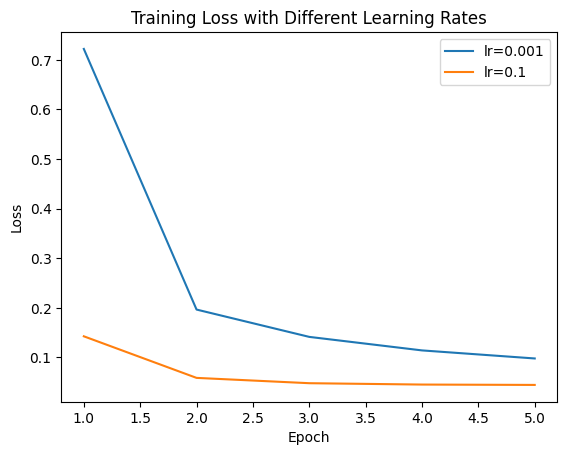

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt  # Thêm import này để sử dụng plt

# Thiết lập thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chuẩn bị dữ liệu MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# Định nghĩa mô hình CNN
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=0)   # 1x28x28 -> 16x26x26
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)  # 16x13x13 -> 32x11x11
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)        # Pooling: 26x26 -> 13x13, 11x11 -> 5x5
        self.fc1 = nn.Linear(32 * 5 * 5, 10)                                # 32x5x5 -> 10

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Qua conv1, ReLU, pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Qua conv2, ReLU, pooling
        x = x.view(-1, 32 * 5 * 5)               # Flatten
        x = self.fc1(x)                           # Fully connected
        return x

# Thử với learning rate = 0.001
model = MNIST_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # Thay lr=0.001

losses_001 = []
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    losses_001.append(avg_loss)
    print(f'[lr=0.001] Epoch {epoch + 1}, Loss: {avg_loss:.3f}')

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy_001 = 100 * correct / total
print(f'[lr=0.001] Accuracy on test set: {accuracy_001:.2f}%')

# Thử với learning rate = 0.1
model = MNIST_CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)  # Thay lr=0.1

losses_01 = []
for epoch in range(5):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    losses_01.append(avg_loss)
    print(f'[lr=0.1] Epoch {epoch + 1}, Loss: {avg_loss:.3f}')

correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy_01 = 100 * correct / total
print(f'[lr=0.1] Accuracy on test set: {accuracy_01:.2f}%')

# Vẽ biểu đồ mất mát
plt.plot(range(1, 6), losses_001, label='lr=0.001')
plt.plot(range(1, 6), losses_01, label='lr=0.1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with Different Learning Rates')
plt.legend()
plt.show()

# Phân tích ảnh hưởng của Learning Rate đến hiệu suất mô hình

## 1. Độ chính xác trên tập test với mỗi Learning Rate

- **Learning rate = 0.001**  
  - Độ chính xác trên tập test: **97.53%**  
- **Learning rate = 0.1**  
  - Độ chính xác trên tập test: **98.47%**  

### So sánh:
- Với **lr = 0.001**, độ chính xác **thấp hơn** (**97.53%**) so với **lr = 0.1** (**98.47%**). Điều này cho thấy **learning rate thấp** làm mô hình **học chậm**, chưa đạt hiệu suất tối ưu trong 5 epoch.  
- So với **learning rate mặc định lr = 0.01** (**độ chính xác ~98.2% từ các kết quả trước**):  
  - **lr = 0.1** cho **độ chính xác cao hơn**.  
  - **lr = 0.001** cho **độ chính xác thấp hơn**.

---

## 2. Biểu đồ mất mát thay đổi ra sao?

### Quan sát từ biểu đồ:
- **Với lr = 0.001 (đường màu xanh)**:  
  - Mất mát giảm **chậm**, từ **0.722 (epoch 1) xuống 0.088 (epoch 5)**.  
  - Quá trình giảm **ổn định** nhưng tốc độ chậm, cho thấy mô hình **chưa học đủ nhanh để hội tụ tốt** trong 5 epoch.  

- **Với lr = 0.1 (đường màu cam)**:  
  - Mất mát giảm **rất nhanh**, từ **0.143 (epoch 1) xuống 0.045 (epoch 5)**.  
  - Xuất hiện **dao động nhẹ** (ví dụ: từ **0.048 ở epoch 4** xuống **0.045 ở epoch 5**), cho thấy mô hình **học nhanh nhưng có thể gặp vấn đề về ổn định**.  

### Xu hướng:
- **lr = 0.001**: Mất mát **giảm chậm và ổn định**, nhưng **chưa hội tụ tốt**.  
- **lr = 0.1**: Mất mát **giảm nhanh**, nhưng có **dao động nhẹ**, cho thấy mô hình có thể **đã vượt qua điểm tối ưu ở một số bước**.  

---

## 3. Ảnh hưởng của Learning Rate đến quá trình học
**Learning rate ảnh hưởng đến tốc độ và độ ổn định của quá trình học**:  
- **Learning rate thấp** (như **0.001**) làm mô hình **học chậm, ổn định**, nhưng **có thể không hội tụ đủ** trong số epoch giới hạn.  
- **Learning rate cao** (như **0.1**) giúp mô hình **học nhanh hơn, đạt độ chính xác cao hơn**, nhưng **dễ dao động** và có thể **vượt qua điểm tối ưu**.  
- **Cần chọn learning rate phù hợp** để **cân bằng giữa tốc độ học và độ ổn định**.  


## Câu 4: Vẽ thêm feature map từ tầng tích chập thứ hai

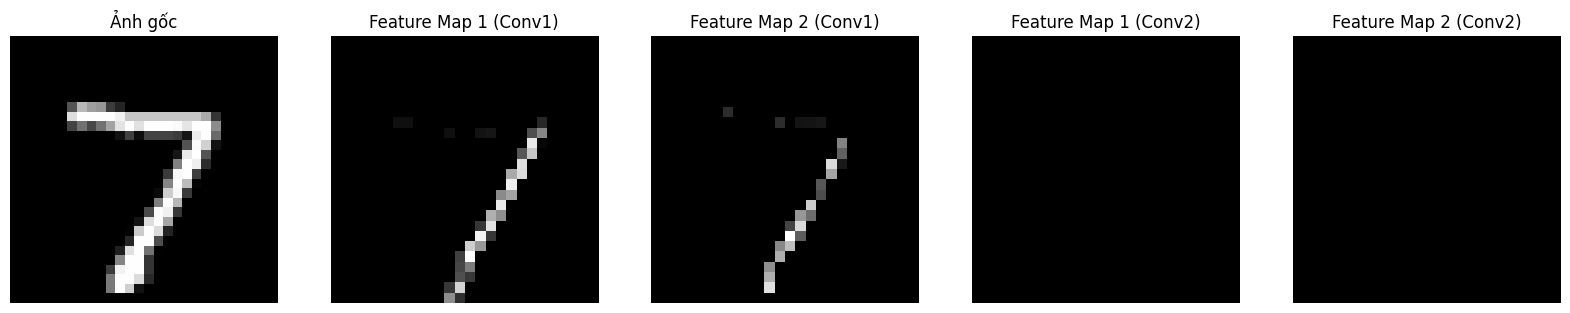

In [5]:
# Sửa hàm visualize_feature_map
def visualize_feature_map():
    model.eval()
    images, _ = next(iter(test_loader))
    img = images[0].unsqueeze(0).to(device)
    
    # Tính feature map từ conv1 và conv2
    conv1_output = torch.relu(model.conv1(img))  # 1x16x26x26
    conv2_output = torch.relu(model.conv2(model.pool(conv1_output)))  # 16x13x13 -> 32x11x11
    
    # Vẽ ảnh gốc và feature map
    plt.figure(figsize=(20, 4))  # Tăng kích thước thành 5 cột
    plt.subplot(1, 5, 1)
    plt.title("Ảnh gốc")
    plt.imshow(img.cpu().squeeze(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 5, 2)
    plt.title("Feature Map 1 (Conv1)")
    plt.imshow(conv1_output[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 5, 3)
    plt.title("Feature Map 2 (Conv1)")
    plt.imshow(conv1_output[0, 1].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 5, 4)
    plt.title("Feature Map 1 (Conv2)")
    plt.imshow(conv2_output[0, 0].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(1, 5, 5)
    plt.title("Feature Map 2 (Conv2)")
    plt.imshow(conv2_output[0, 1].cpu().detach().numpy(), cmap='gray')
    plt.axis('off')
    plt.show()

visualize_feature_map()

# Phân tích sự khác biệt giữa Feature Map từ Conv1 và Conv2

## 1. Sự khác biệt giữa Feature Map từ Conv1 và Conv2

### **Feature Map từ Conv1 (Feature Map 1 và 2 của Conv1)**
- Các feature map từ **conv1** vẫn giữ được **hình dạng tổng quát** của số "7" trong ảnh gốc.  
- Chúng hiển thị các **đặc trưng cấp thấp** như **cạnh và đường nét cơ bản** của số "7".  
- **Ví dụ**:  
  - **Feature Map 1 (Conv1)** cho thấy các **đường thẳng dọc và ngang** của số "7".  
  - **Feature Map 2 (Conv1)** tập trung vào các phần khác của số nhưng vẫn khá **chi tiết** và gần với ảnh gốc.  

### **Feature Map từ Conv2 (Feature Map 1 và 2 của Conv2)**
- Các feature map từ **conv2** trở nên **trừu tượng hơn** và **mất đi hình dạng rõ ràng** của số "7".  
- Chúng không còn hiển thị các **đường nét cụ thể**, mà thay vào đó là các **vùng sáng/tối** đại diện cho các **đặc trưng phức tạp hơn**.  
- **Quan sát**:  
  - Cả **Feature Map 1 và 2 của Conv2** đều rất **tối**, chỉ có một **vài điểm sáng nhỏ**.  
  - Điều này cho thấy tầng này tập trung vào các **đặc trưng cấp cao hơn** thay vì các **chi tiết cụ thể**.  

### **Sự khác biệt chính**
| Feature Map | Đặc điểm chính | Độ chi tiết |
|-------------|---------------|------------|
| **Conv1**  | Giữ hình dạng tổng quát, phát hiện cạnh và đường nét | Chi tiết hơn, giống ảnh gốc |
| **Conv2**  | Trừu tượng hơn, tập trung vào đặc trưng cấp cao | Mất chi tiết, ít giống ảnh gốc |

---

## 2. Sự khác biệt giữa feature map từ các tầng khác nhau
Feature map từ các tầng tích chập khác nhau **phản ánh mức độ trừu tượng** của đặc trưng: **tầng đầu tiên (conv1)** thường phát hiện các **đặc trưng cấp thấp** như **cạnh và đường nét**, nên **giữ được chi tiết của ảnh gốc**. **Tầng sau (conv2)** học các **đặc trưng cấp cao hơn**, như **các mẫu hình phức tạp**, dẫn đến feature map **trừu tượng hơn** và **ít giống ảnh gốc**. Sự khác biệt này thể hiện cách **mạng CNN dần chuyển từ chi tiết cụ thể sang các biểu diễn tổng quát** qua các tầng.  
